In [0]:
%matplotlib inline
import copy
import random
import numpy as np
from matplotlib import pyplot as plt

In [0]:
class Building:
    '''
    The building class creates the building that the elevator operates in
    and the passengers that the elevator needs to service
    
    The passengers are created by giving a higher probability of getting on
    and off at the ground floor. The probabilities of getting or and off at
    other floors are uniform. Sampling is done without replacement to prevent
    origin and destination floors from being the same.
    
    Parameters
    -------
    n_floors: allows setting the number of floors in the building
    n_passengers: allows setting the number of passengers in the building
    '''
    def __init__(self, n_floors, n_passengers):
        self.n_floors = n_floors
        self.passengers = []
        for _ in range(n_passengers):
            ground_prob = 0.3  # probability of sampling ground floor
            origin, destination  = np.random.choice(np.arange(0,self.n_floors+1), \
                  p=[ground_prob]+[(1-ground_prob)/self.n_floors]*self.n_floors, replace=False,size=2)
            self.passengers.append(Passenger(origin, destination))

    def building_report(self):
        print ("{:d} passengers still waiting for the elevator.".format(len(self.passengers)))

class Passenger:
    '''
    Passenger class that instantiates each passenger with their origin floor, destination floor,
    and the direction they are headed in the building.
    '''
    def __init__(self, origin, destination):
        self.origin = origin
        self.destination = destination
        self.direction = int(self.destination < self.origin)   # 0=up, 1=down

class Elevator:
    '''
    Parent Elevator class that defines the key attributes and the reporting for the simulation.
    
    Parameters
    ----------
    building : Building object
        Represents the building and contains the passengers waiting for the elevator
    capacity : int
        The number of people that can fit in the elevator
    passengers : list
        List of passengers in the elevator, their origin and destination
    floor : int
        The current floor of the elevator in the building, starting from 0
    direction : int
        The direction of the elevator (0 = up, 1 = down)
    movement : int
        Tracks number of floors travelled by the elevator during the simulation
    stops : int
        Counts the number of stops the elevator made to onboard/offboard passengers
    '''
    def __init__(self, building, capacity):
        self.building = building
        self.capacity = capacity
        self.passengers = []   # starting with no passenger
        self.floor = 0         # starting at floor 0
        self.direction = 0     # 0=up, 1=down
        self.movement = 0      # count total movement
        self.stops = 0         # count total stops
        
    def next_floor(self):
        
        '''
        If the elevator is not at the top or the bottom floor,
        the method moves the elevator up or down by one floor and increments the movement counter.
        
        If the elevator is at the top or the bottom floor, the method tells the elevator to change direction.
        The method currently counts a change of direction as one extra movement.
        
        Whether a floor contributes towards the number of stops made will be counted in Elevator
        specific methods as we need the simulated elevator to "stop" at each floor to make evaluation
        whether if the actual elevator needs to stop at that particular floor.
        '''
        
        if self.direction == 0:
            if self.floor < self.building.n_floors:
                self.floor += 1
                self.movement += 1
                if self.floor == self.building.n_floors:
                    return True
            else:   # reached the top, change direction
                self.direction = 1
        else:
            if self.floor > 0:
                self.floor -= 1
                self.movement += 1
                if self.floor == 0:
                    return True
            else:   # reached the bottom, change direction
                self.direction = 0
        return False

    def elevator_report(self):
        '''
        The elevator_report method reports the floor the elevator is 
        currently at and how many passengers are on it.
        '''
        print ("Elevator at {:d} floor.".format(self.floor))
        print ("{:d} passengers on elevator.".format(len(self.passengers)))

In [0]:
class StupidElevator(Elevator):
    '''
    Child of the Elevator class with a straightforward strategy (example given in the assignment).
    Goes one direction up and stops at every floor, picking up and dropping off any passenger possible.
    
    Here, we define the on- and off-boarding methods and movement method for this strategy.
    '''
    def __init__(self, building, capacity):
        super().__init__(building, capacity)

    def on_boarding(self):
        on_boarding_index = []
        remaining_capacity = self.capacity - len(self.passengers)            #Counts the remaining capacity in the elevator
        if remaining_capacity != 0:
          for index, passenger in enumerate(self.building.passengers):
              if passenger.origin == self.floor:                             #Checks whether there are people on the current floor to on board
                  on_boarding_index.append(index)
                  self.passengers.append(passenger)
                  if len(on_boarding_index) == remaining_capacity:           #Stops on-boarding once the elevator is full
                      break
          for index in sorted(on_boarding_index, reverse=True):
              del self.building.passengers[index]                            #Once passenger boarded, delete them from the building passengers

    def off_boarding(self):
        off_boarding_index = []
        for index, passenger in enumerate(self.passengers):
            if self.floor == passenger.destination:                          #Off board passenger at their destination floor
                off_boarding_index.append(index)
        for index in sorted(off_boarding_index, reverse=True):
            del self.passengers[index]                                       #And remove them from the list of passengers in elevator
            
    def evaluate(self):
        '''
        Calls the next_floor method which moves the elevator to the next floor.
        
        Checks whether the elevator has reached the top/bottom floor, and if it has not,
        adds stops and makes the elevator on and off board passengers.
        
        Note: if the elevator reached the top/bottom, the direction of the elevator is
        changed by the next_floor method.
        '''
        reached_edge_floor = self.next_floor()
        
        if not reached_edge_floor:
            self.off_boarding()
            self.on_boarding()
            
            self.stops += 1

In [0]:
class SmartElevator(Elevator):
    '''
    Child of the Elevator class with an improved strategy.
    This elevator stops at floors where button is pressed,
    and onboards passengers in the travelling direction of the elevator.
    
    Here, we define the on- and off-boarding methods and movement method for this strategy.
    '''
    def __init__(self, building, capacity):
        super().__init__(building, capacity)
      
    def find_passenger_on_direction(self):
        passenger_on_direction = False
        # Checks whether a passenger on the elevator is going the same direction as the elevator, and returns True if there is
        for passenger in self.passengers:
                if int(passenger.destination > self.floor) != self.direction:
                    passenger_on_direction = True
                    break
        # Checks whether a person is above the elevator, and returns True to signify that there is a passenger in the direction of the elevator
        # If the elevator is full, skip the check and assume there is no passenger going in the same direction.
        if not passenger_on_direction:
          if self.capacity - len(self.passengers) == 0:
            passenger_on_direction = False
          else:
            for passenger in self.building.passengers:
              if int(passenger.origin > self.floor) != self.direction:
                  passenger_on_direction = True
                  break
        # Changes direction when it does not find any passengers in the building in its direction or in the elevator going the same direction
        if not passenger_on_direction:
            self.direction = int(not bool(self.direction))
        return passenger_on_direction

    def on_boarding(self):
        '''
        The method does the same as the StupidElevator on_boarding method
        apart from that it onboards passengers only if they are going the same direction
        and returns 1 when someone has on-boarded
        '''
        on_boarding_index = []
        remaining_capacity = self.capacity - len(self.passengers)
        if remaining_capacity != 0:
          for index, passenger in enumerate(self.building.passengers):
              if passenger.direction == self.direction and passenger.origin == self.floor: 
                  on_boarding_index.append(index)
                  self.passengers.append(passenger)
                  if len(on_boarding_index) == remaining_capacity:
                      break
          for index in sorted(on_boarding_index, reverse=True):
              del self.building.passengers[index]
        return int(len(on_boarding_index) != 0)

    def off_boarding(self):
        '''
        The method does the same as the StupidElevator off_boarding method
        apart from that it returns 1 if someone has off-boarded.
        '''
        off_boarding_index = []
        for index, passenger in enumerate(self.passengers):
            if self.floor == passenger.destination:
                off_boarding_index.append(index)
        for index in sorted(off_boarding_index, reverse=True):
            del self.passengers[index]
        return int(len(off_boarding_index) != 0)

    def evaluate(self):
        '''
        Evaluates whether the passengers on the current floor are going the same direction
        as the elevator, and calculates stops made.
        '''
        passenger_on_direction = self.find_passenger_on_direction()
        if passenger_on_direction:                             #if there is a passenger in its path or on it going in the same direction
            edge_reached = self.next_floor()                   #Move the elevator the next floor and check if the elevator reaches the edge
        else:                                                  #if we do not find a passenger, the elevator changes direction
            edge_reached = False                               #we set edge_reached to False because we need to do on-boarding again
            
        if not edge_reached:                                   #if the elevator has not reached the edge, do on- and off-boarding
            off_boarding_stop = self.off_boarding()
            on_boarding_stop = self.on_boarding()
            
            if off_boarding_stop or on_boarding_stop:          #adds a stop only if someone has on- or off-boarded
                self.stops += 1

In [0]:
class Simulation:
  
    def __init__(self):
        pass
    
    def elevator_start(self, elevator, markup):
        elevator.on_boarding() #let passengers at floor 0 to board
        while not(len(elevator.building.passengers) == 0 and len(elevator.passengers) == 0):
            #runs until all building passengers have been transported and all elevator passengers have offboarded
            elevator.evaluate()
            if markup:
                elevator.elevator_report()
                elevator.building.building_report()
        return elevator.movement, elevator.stops
      
    def run_simulation(self, n_floors, n_passengers, elevator_capacity, elevator_strategy, markup=False):
        #generate a building with passengers
        building = Building(n_floors, n_passengers)
        
        #move passengers
        if elevator_strategy == "STUPID":
            elevator = StupidElevator(building, elevator_capacity)
            movement, stops = self.elevator_start(elevator, markup)
            if markup:
                print ("------")
                print ("Total movement: {:d}; total stops: {:d}".format(movement, stops))
            else:
                return movement, stops
              
        elif elevator_strategy == "SMART":
            elevator = SmartElevator(building, elevator_capacity)
            movement, stops = self.elevator_start(elevator, markup)
            if markup:
                print ("------")
                print ("Total movement: {:d}; total stops: {:d}".format(movement, stops))
            else:
                return movement, stops
            
        elif elevator_strategy == "BOTH":
            #deepcopy is used so the simulation of strategies run on same data
            if markup: print ("- Stupid Elevator -")
            building_copy = copy.deepcopy(building)
            stupid_elevator = StupidElevator(building_copy, elevator_capacity)
            stupid_movement, stupid_stops = self.elevator_start(stupid_elevator, markup)
            if markup: print ("- Smart Elevator -")
            building_copy = copy.deepcopy(building)
            smart_elevator = SmartElevator(building_copy, elevator_capacity)
            smart_movement, smart_stops = self.elevator_start(smart_elevator, markup)
            if markup:
                print ("------")
                print ("Total movement for stupid elevator: {:d}; total stops: {:d}".format(stupid_movement, stupid_stops))
                print ("Total movement for smart elevator: {:d}; total stops: {:d}".format(smart_movement, smart_stops))
            else:
                return stupid_movement, stupid_stops, smart_movement, smart_stops

    def batch_simulation(self, n_floors, n_passengers, elevator_capacity, markup=False, repetitions=100):
        #run both strategy at the same time and plot comparison
        simulation_result_array = []
        for _ in range(repetitions):
            simulation_result_array.append(self.run_simulation(n_floors, n_passengers, elevator_capacity, "BOTH"))
        simulation_result_array = np.array(simulation_result_array)
        simulation_result_mean = np.mean(simulation_result_array, axis=0)
        if markup:
          print ("{:d} simulation performed".format(repetitions))
          print ("Average movement for stupid elevator: {:.2f}; total stops: {:.2f}".format(simulation_result_mean[0], simulation_result_mean[1]))
          print ("Average movement for smart elevator: {:.2f}; total stops: {:.2f}".format(simulation_result_mean[2], simulation_result_mean[3]))
        else:
          return simulation_result_mean
        
    def plot_result(self, x_set, result_set, x_unit):
        plt.plot(x_set, result_set[0], label='Stupid Elevator Moves')
        plt.plot(x_set, result_set[2], label='Smart Elevator Moves')
        plt.legend()
        plt.xlabel("Number of {:s} in the Building".format(x_unit))
        plt.ylabel('Total Number of Floors Travelled')
        plt.show()
        
        plt.plot(x_set, result_set[1], label='Stupid Elevator Stops')
        plt.plot(x_set, result_set[3], label='Smart Elevator Stops')
        plt.legend()
        plt.xlabel("Number of {:s} in the Building".format(x_unit))
        plt.ylabel('Total Elevator Stops')
        plt.show()
      
    def floor_test(self, n_floors_set, n_passengers, elevator_capacity):
        # Test elevator performance with increasing number of floors
        simulation_result_set = []
        for n_floors in n_floors_set:
            simulation_result_set.append(self.batch_simulation(n_floors, n_passengers, elevator_capacity))
        simulation_result_set = np.array(simulation_result_set).T
        x_label = "Number of Floors in the Building"
        self.plot_result(n_floors_set, simulation_result_set, "Floors")
      
    def passenger_test(self, n_floors, n_passengers_set, elevator_capacity):
        # Test elevator performance with increasing number of building passengers
        simulation_result_set = []
        for n_passengers in n_passengers_set:
            simulation_result_set.append(self.batch_simulation(n_floors, n_passengers, elevator_capacity))
        simulation_result_set = np.array(simulation_result_set).T
        self.plot_result(n_passengers_set, simulation_result_set, "Passengers")

In [0]:
# Run a simple test case
n_floors = 3
n_passengers = 6
elevator_capacity = 5

S = Simulation()
S.run_simulation(n_floors, n_passengers, elevator_capacity, "BOTH", True)

- Stupid Elevator -
Elevator at 1 floor.
4 passengers on elevator.
1 passengers still waiting for the elevator.
Elevator at 2 floor.
2 passengers on elevator.
0 passengers still waiting for the elevator.
Elevator at 3 floor.
2 passengers on elevator.
0 passengers still waiting for the elevator.
Elevator at 3 floor.
2 passengers on elevator.
0 passengers still waiting for the elevator.
Elevator at 2 floor.
2 passengers on elevator.
0 passengers still waiting for the elevator.
Elevator at 1 floor.
1 passengers on elevator.
0 passengers still waiting for the elevator.
Elevator at 0 floor.
1 passengers on elevator.
0 passengers still waiting for the elevator.
Elevator at 0 floor.
0 passengers on elevator.
0 passengers still waiting for the elevator.
- Smart Elevator -
Elevator at 1 floor.
3 passengers on elevator.
2 passengers still waiting for the elevator.
Elevator at 2 floor.
0 passengers on elevator.
2 passengers still waiting for the elevator.
Elevator at 2 floor.
1 passengers on elev

In [0]:
# Batch simulation test
n_floors = 30
n_passengers = 50
elevator_capacity = 12

S.batch_simulation(n_floors, n_passengers, elevator_capacity, True)

100 simulation performed
Average movement for stupid elevator: 129.70; total stops: 129.70
Average movement for smart elevator: 109.29; total stops: 49.63


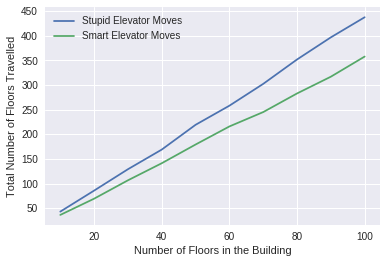

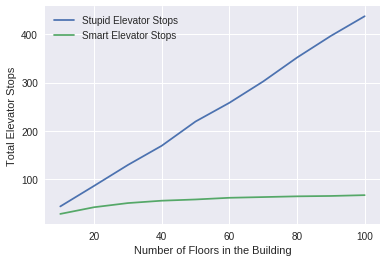

In [0]:
n_floors_set = [n for n in range(10, 101, 10)]
n_passengers = 50
elevator_capacity = 12

S.floor_test(n_floors_set, n_passengers, elevator_capacity)

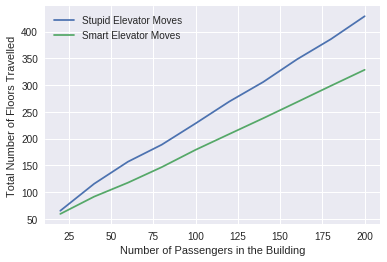

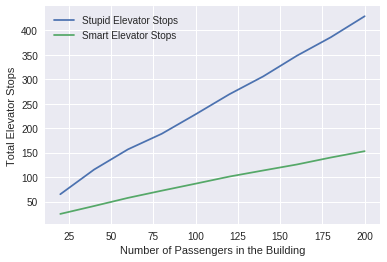

In [0]:
n_floors_set = 50
n_passengers_set = [n for n in range(20, 201, 20)]
elevator_capacity = 12

S.passenger_test(n_floors, n_passengers_set, elevator_capacity)